# Решение ОДУ на Julia для робототехники

Сегодня будем исследовать робототехнику с позиции ОДУ. ОДУ там буквально везде: это и управление (см. системное управление, управляющее воздействие), и расчёт динамики робота (то, как ему двигаться), и моделирование работы робота в физической среде. Использование корректных методов решения ОДУ очень важно в этих задачах для обеспечения тех или иных целей (время реакции, точность реакции или адекватность модели, например.) *тут может быть [видео](https://vkvideo.ru/video-49770594_171647393) (или его [оригинал](https://www.youtube.com/watch?v=E2evC2xTNWg)), где робо-рука крушит половину кухни, пока готовит завтрак*

Для этой задачи мы попробуем использовать язык программирования Julia, который содержит большое количество пакетов для математики и анализа данных. Особенно богата у Julia библиотека для решения дифференциальных уравнений DifferentialEquations. Среди её зависимостей мы можем заметить уже знакомые нам, как например Sundials.

На практике для робототехники используют разные инструменты. В разных случаях популярны и С/С++, и Python, и Matlab и другие решения. Julia также является весьма современным и актуальным подходом. В конце ноутбука можно будет найти ссылки на некоторые дополнительные ресурсы по этой теме.



**Learning Objectives:**
- Learn how to set up a robotics simulation using ODE models in Julia.
- Experiment with different ODE solvers (e.g., Tsit5, Rodas5, CVODE_BDF) and see how they differ in handling non‑stiff and stiff systems.
- Understand the impact of solver choice on accuracy, stability, and execution time.

This notebook is designed to run on Binder
[Binder Link](https://mybinder.org/).

In [14]:
##############################
# Package Setup
##############################

using Pkg
# If running for the first time on Binder, uncomment the following lines:
# Pkg.add("DifferentialEquations")
# Pkg.add("Plots")
# Pkg.add("MeshCat")
# Pkg.add("RigidBodyDynamics")
# Pkg.add("IJulia")
# Pkg.add("ModelingToolkit")

# Pkg.resolve()

# using IJulia
# notebook()

using DifferentialEquations
using Plots
using Sundials

# Set a default plot theme
default(; lw=2, size=(600,400))

## 1. Робототехника

В робототехнике распространенной простой моделью является **двойной интегратор**, который может представлять линейное движение робота. Вектор состояния определяется как:

- **u[1]:** Позиция (position)
- **u[2]:** Скорость (velocity)

Динамика задаётся следующим уравнением:

- $$ \frac{d}{dt} (\text{position}) = \text{velocity} $$
- $$ \frac{d}{dt} (\text{velocity}) = -k \times (\text{position}) - c \times (\text{velocity}) $$

где $k$ - коэффициент упругости, а $c$ - коэффициент затухания. Эта простая модель позволит нам исследовать поведение как нежестких, так и жестких материалов, регулируя параметры.

In [15]:
##############################
# Define the ODE Model
##############################

# The robot dynamics function for the double integrator
function robot_dynamics!(du, u, p, t)
    # u[1] = position, u[2] = velocity
    du[1] = u[2]                           # d(position)/dt = velocity
    du[2] = -p[1]*u[1] - p[2]*u[2]           # acceleration = -k*position - c*velocity
end

# Initial conditions: robot starts at position 1.0 with zero initial velocity
u0 = [1.0, 0.0]

# Time span for the simulation: 0 to 10 seconds
tspan = (0.0, 10.0)

# Parameters: p = [spring constant, damping coefficient]
p = [2.0, 0.5]

# Create the ODE problem
prob = ODEProblem(robot_dynamics!, u0, tspan, p)


ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 2-element Vector{Float64}:
 1.0
 0.0

## 2. Решение задачи Коши (ОДУ) разными методами

Библиотека DifferentialEquations.jl предлагает широкий выбор реализаций методов решения дифференциальных уравнений. Давайте рассмотрим как можно решить уравнение для двойного инегратора при помощи этих методов и сравним результаты. Можно свериться с [Документацией DifferentialEquations.jl](https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/) для дополнительных деталей.

Для начала будем использовать следующие методы:

- **Tsit5**: не жёсткий, явный метод Рунге-Кутты
- **Rodas5**: неявный метод, который потенциально подходит для жёстких систем
- **CVODE_BDF**: метод из библиотеки Sundials (часто используется для больших жёстких систем)

Не стесняйтесь настраивать параметры (например, увеличивать коэффициент затухания), чтобы увидеть, как методы реагируют на более жёсткую динамику.

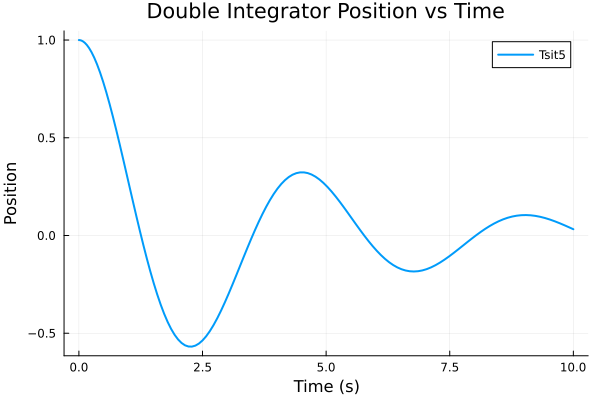

In [16]:
##############################
# Solve using Tsit5 (non-stiff)
##############################

sol_Tsit5 = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)

plot(sol_Tsit5.t, sol_Tsit5[1,:], label="Tsit5", xlabel="Time (s)", ylabel="Position", 
     title="Double Integrator Position vs Time", lw=2)
display(current())


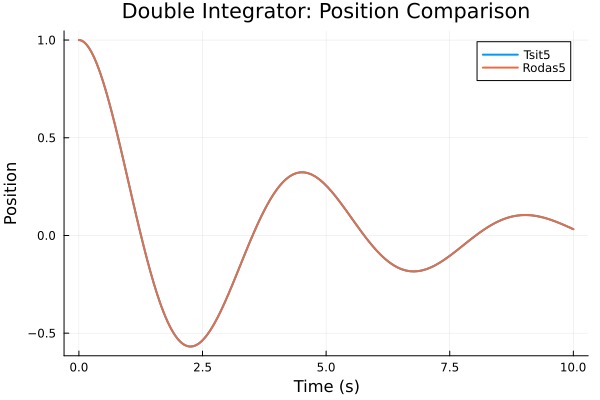

In [17]:
##############################
# Solve using Rodas5 (for stiff systems)
##############################

sol_Rodas5 = solve(prob, Rodas5(), reltol=1e-8, abstol=1e-8)

# Plotting on the same figure for comparison
plot(sol_Tsit5.t, sol_Tsit5[1,:], label="Tsit5", xlabel="Time (s)", ylabel="Position", 
     title="Double Integrator: Position Comparison", lw=2)
plot!(sol_Rodas5.t, sol_Rodas5[1,:], label="Rodas5", lw=2)
display(current())


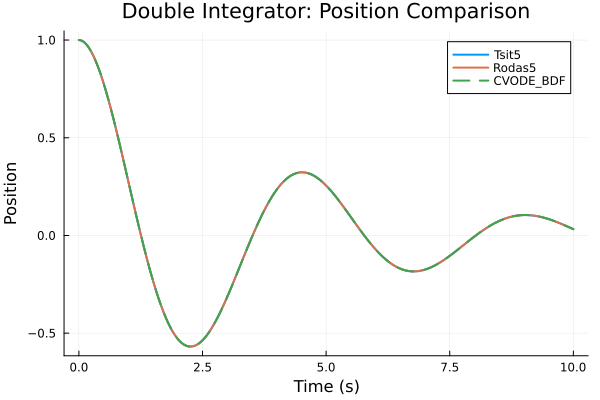

In [18]:
##############################
# Solve using CVODE_BDF (from Sundials, for stiff problems)
##############################

sol_CVODE = solve(prob, CVODE_BDF(), reltol=1e-8, abstol=1e-8)

# Add the solution from CVODE_BDF on our comparison plot
plot!(sol_CVODE.t, sol_CVODE[1,:], label="CVODE_BDF", linestyle=:dash, lw=2)
display(current())


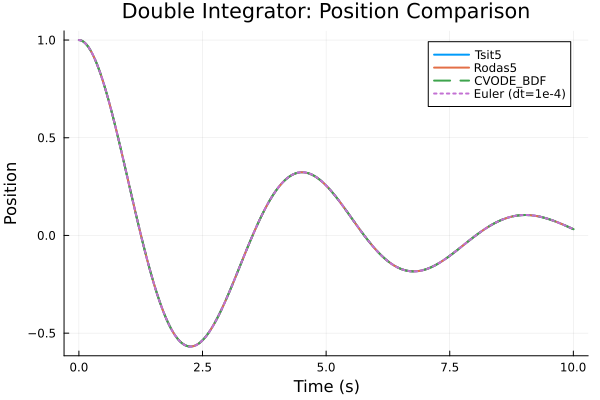

In [19]:
##############################
# Solve using Euler (simple explicit method)
##############################

# Note: Euler method requires a fixed time step (dt)
# We need many steps for reasonable accuracy
sol_Euler = solve(prob, Euler(), dt=1e-4, adaptive=false)

# Add the Euler solution to the comparison plot
# Plot only a subset of points for clarity due to small dt
plot!(sol_Euler.t[1:100:end], sol_Euler[1,1:100:end], label="Euler (dt=1e-4)", linestyle=:dot, lw=2)
display(current())

In [20]:
##############################
# Timing Analysis
##############################

p_stiff = [2.0, 50.0]
prob_stiff = ODEProblem(robot_dynamics!, u0, tspan, p_stiff)

println("Timing for Non-Stiff Problem (reltol=1e-8, abstol=1e-8):")
@time solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);
@time solve(prob, Rodas5(), reltol=1e-8, abstol=1e-8);
@time solve(prob, CVODE_BDF(), reltol=1e-8, abstol=1e-8);
@time solve(prob, Euler(), dt=1e-4, adaptive=false); # Euler with fixed dt

println("\nTiming for Stiff Problem (reltol=1e-6, abstol=1e-6):")
@time solve(prob_stiff, Tsit5(), reltol=1e-6, abstol=1e-6);
@time solve(prob_stiff, Rodas5(), reltol=1e-6, abstol=1e-6);
@time solve(prob_stiff, CVODE_BDF(), reltol=1e-6, abstol=1e-6);
# @time solve(prob_stiff, Euler(), dt=1e-6, adaptive=false); # Likely very slow

println("\nTiming for Non-Stiff Problem (Loose Tolerances: reltol=1e-3, abstol=1e-3):")
@time solve(prob, Tsit5(), reltol=1e-3, abstol=1e-3);
@time solve(prob, Rodas5(), reltol=1e-3, abstol=1e-3);
@time solve(prob, CVODE_BDF(), reltol=1e-3, abstol=1e-3);

Timing for Non-Stiff Problem (reltol=1e-8, abstol=1e-8):
  0.000114 seconds (2.42 k allocations: 106.609 KiB)
  0.000264 seconds (1.90 k allocations: 83.047 KiB)
  0.000478 seconds (5.44 k allocations: 175.367 KiB)
  0.374508 seconds (800.07 k allocations: 36.885 MiB, 94.13% gc time)

Timing for Stiff Problem (reltol=1e-6, abstol=1e-6):
  0.000123 seconds (2.88 k allocations: 125.703 KiB)
  0.000111 seconds (440 allocations: 20.516 KiB)
  0.000233 seconds (1.92 k allocations: 60.062 KiB)

Timing for Non-Stiff Problem (Loose Tolerances: reltol=1e-3, abstol=1e-3):
  0.000059 seconds (414 allocations: 20.312 KiB)
  0.000107 seconds (375 allocations: 17.938 KiB)
  0.000249 seconds (1.08 k allocations: 37.156 KiB)


## 3. Экспериментирование и анализ

Теперь ваша очередь экспериментировать! Попробуйте выполнить следующие задания:

1. **Добавление решателя:** Добавьте метод Эйлера из библиотеки DifferentialEquations.jl аналогично остальным методам.

2. **Измените параметры:** Увеличьте коэффициент затухания (или коэффициент упругости), чтобы повысить жёсткость модели. Обратите внимание на то, как меняются решения и как некоторые решатели справляются с жёсткой динамикой лучше, чем другие.

3. **Погрешности метода:** Измените относительную (`reltol`) и абсолютную (`abstol`) погрешность при вызове метода `solve()`. Следите за изменениями точности и времени вычислений.

4. **Анализ времени работы:** Используйте макрос "@time", чтобы измерить, сколько времени занимает каждое решение. Например:

   ```julia
   @time solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
   @time solve(prob, Rodas5(), reltol=1e-8, abstol=1e-8)
   ```

5. **Рассуждение:** Ответьте на следующие вопросы своими словами в ячейке Markdown ниже:
   - Как выбор решателя влияет на решение для нежёстких и жёстких режимов?
   - Какие компромиссы вы наблюдаете с точки зрения времени вычислений, точности и стабильности?

Можно свериться с [Документацией DifferentialEquations.jl](https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/) для дополнительных деталей.


Выбор численного решателя ОДУ оказывает существенное влияние на процесс и результат моделирования, особенно при изменении характеристик системы, таких как жёсткость. Для нежёстких систем многие современные адаптивные решатели, как явные (например, Tsit5), так и неявные (Rodas5, CVODE_BDF), обеспечивают точные и сравнимые результаты при достаточно строгих допусках, причём явные методы часто оказываются быстрее из-за меньших вычислительных затрат на шаг. Однако при увеличении жёсткости системы (например, за счёт увеличения коэффициента затухания) явные методы сталкиваются с ограничениями по стабильности, требуя очень малых шагов, что резко увеличивает время вычислений или вовсе приводит к невозможности получить решение. В таких условиях неявные методы, разработанные специально для жёстких задач, демонстрируют своё преимущество: они сохраняют стабильность при значительно больших шагах интегрирования, что делает их гораздо более эффективными по общему времени расчёта, несмотря на потенциально более сложные вычисления на каждом отдельном шаге. Всегда существует компромисс: повышение требуемой точности (уменьшение `reltol` и `abstol`) увеличивает время вычислений, но улучшает качество решения. Для жёстких систем стабильность часто становится более строгим ограничением для явных методов, чем точность, вынуждая использовать малые шаги даже при невысоких требованиях к точности. Таким образом, выбор оптимального решателя зависит от баланса между требуемой точностью, доступным временем вычислений и свойствами самой динамической системы, в первую очередь её жёсткостью.

---

# Дальше дополнительные задания и заключительный вопрос в самом конце.

## 4. Визуализация с MeshCat
При работе с роботами можно удобно визуализировать работу при помощи MeshCat (на сколько я поняла, к сожалению не получится использовать его с Binder, только локально). Но Вы можете попробовать её поднять на Binder, либо локально. 

In [21]:
using MeshCat
vis = Visualizer()

open(vis)
setobject!(vis, HyperSphere(Point(0.0, 0.0, 0.0), 0.5))

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


Could not open browser automatically: Base.IOError("could not spawn `xdg-open http://127.0.0.1:8700`: no such file or directory (ENOENT)", -2)
Please open the following URL in your browser:
http://127.0.0.1:8700


LoadError: UndefVarError: `HyperSphere` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing GeometryBasics in the current active module Main

## 5. Примеры TORA.jl для 2-DoF (двойного маятника)

DoF - степень свободы

В этом примере мы используем пакет **TORA.jl** для построения и моделирования модели двойного маятника.

Пример взят [отсюда](https://juliarobotics.org/RigidBodyDynamics.jl/dev/generated/1.%20Quickstart%20-%20double%20pendulum/1.%20Quickstart%20-%20double%20pendulum/#)

In [22]:
using RigidBodyDynamics
using SVector
using Plots

g = -9.81 # gravitational acceleration in z-direction
world = RigidBody{Float64}("world")
doublependulum = Mechanism(world; gravity = SVector(0, 0, g))

axis = SVector(0., 1., 0.) # joint axis
I_1 = 0.333 # moment of inertia about joint axis
c_1 = -0.5 # center of mass location with respect to joint axis
m_1 = 1. # mass
frame1 = CartesianFrame3D("upper_link") # the reference frame in which the spatial inertia will be expressed
inertia1 = SpatialInertia(frame1,
    moment=I_1 * axis * axis',
    com=SVector(0, 0, c_1),
    mass=m_1)

srcdir = dirname(pathof(RigidBodyDynamics))
urdf = joinpath(srcdir, "..", "test", "urdf", "Acrobot.urdf")
parse_urdf(urdf)


state = MechanismState(doublependulum)

set_configuration!(state, shoulder, 0.3)
set_configuration!(state, elbow, 0.4)
set_velocity!(state, shoulder, 1.)
set_velocity!(state, elbow, 2.);

q = configuration(state)
v = velocity(state)

transform(state, Point3D(frame_after(elbow), zero(SVector{3})),
    default_frame(world))

transform_to_root(state, frame_after(elbow))

relative_transform(state, frame_after(elbow), frame_after(shoulder))

center_of_mass(state)

mass_matrix(state)

v̇ = similar(velocity(state)) # the joint acceleration vector, i.e., the time derivative of the joint velocity vector v
v̇[shoulder][1] = 1
v̇[elbow][1] = 2
inverse_dynamics(state, v̇)

ts, qs, vs = simulate(state, 5., Δt = 1e-3);


LoadError: ArgumentError: Package SVector not found in current path.
- Run `import Pkg; Pkg.add("SVector")` to install the SVector package.

## 6. Свободные осциляции для 1-DoF и 2-DoF

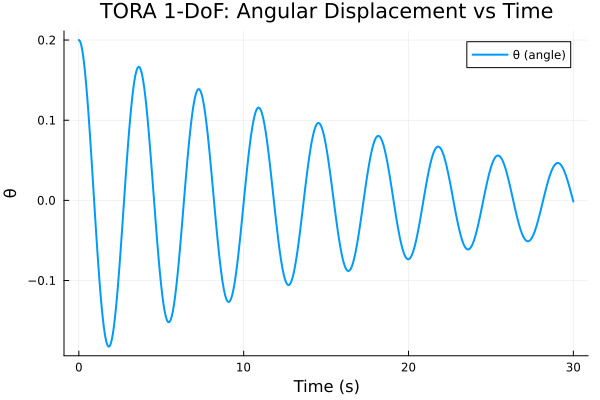

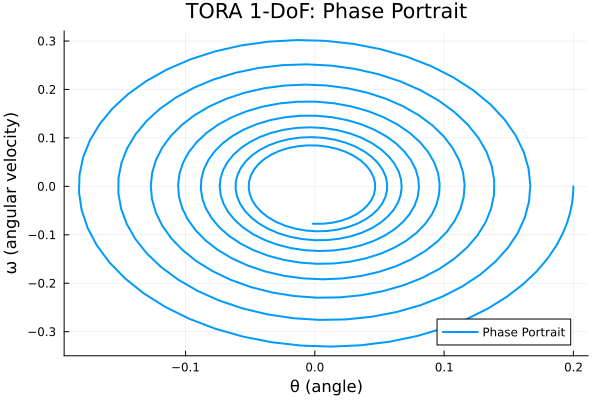

In [23]:
##############################
# TORA 1-DoF Model
##############################

# The ODE for a 1-DoF TORA system.
# Equation: θ'' + d θ' + c * sin(θ) = input, (we set input = 0 for free oscillation)
    function tora1dof!(du, u, p, t)
        d, c, input = p  # damping, stiffness, and external input torque
        theta, omega = u
        du[1] = omega
        du[2] = -d * omega - c * sin(theta) + input
    end
    
    # Initial condition: small initial displacement, starting from rest.
    u0_tora1 = [0.2, 0.0]
    # Time span: simulate over 30 seconds.
    tspan_tora1 = (0.0, 30.0)
    # Parameters: [damping, stiffness, input]. Set input = 0 for free oscillation.
    p_tora1 = [0.1, 3.0, 0.0]
    
    # Define and solve the ODE problem
    prob_tora1 = ODEProblem(tora1dof!, u0_tora1, tspan_tora1, p_tora1)
    sol_tora1 = solve(prob_tora1, Tsit5(), reltol=1e-8, abstol=1e-8)
    
    # Visualize the results:
    # (a) θ vs. Time
    plt1 = plot(sol_tora1.t, sol_tora1[1,:],
                label="θ (angle)",
                xlabel="Time (s)",
                ylabel="θ",
                title="TORA 1-DoF: Angular Displacement vs Time",
                lw=2)
    
    # (b) Phase Portrait: θ vs. ω
    plt2 = plot(sol_tora1[1,:], sol_tora1[2,:],
                label="Phase Portrait",
                xlabel="θ (angle)",
                ylabel="ω (angular velocity)",
                title="TORA 1-DoF: Phase Portrait",
                lw=2,
                legend=:bottomright)
    
    display(plt1)
    display(plt2)

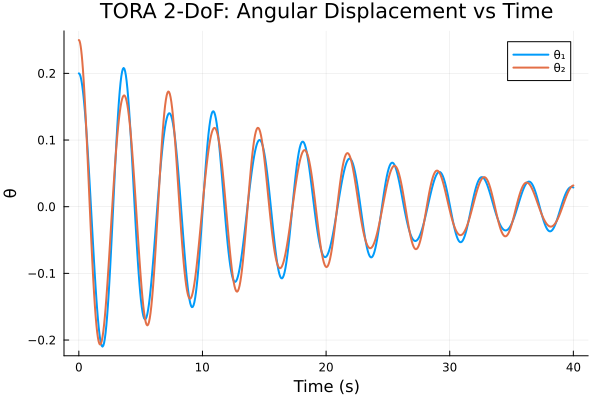

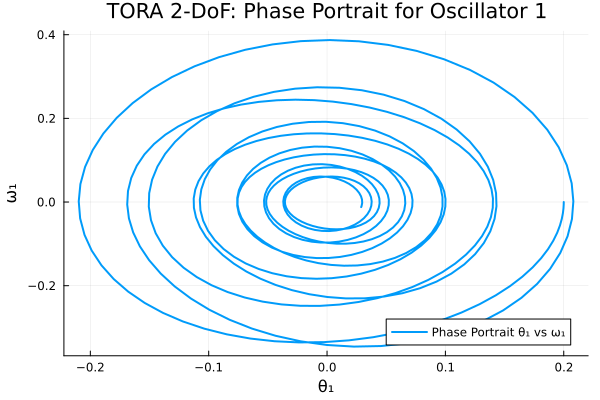

In [24]:
##############################
# TORA 2-DoF Model
##############################

# The ODE for a 2-DoF coupled TORA system.
# Equations:
# θ₁'' + d₁ θ₁' + c₁ sin(θ₁) + k*(θ₁ - θ₂) = input₁,
# θ₂'' + d₂ θ₂' + c₂ sin(θ₂) - k*(θ₁ - θ₂) = input₂.
function tora2dof!(du, u, p, t)
    # Unpack parameters:
    d1, c1, d2, c2, k, input1, input2 = p
    # Unpack state variables:
    theta1, theta2, omega1, omega2 = u
    du[1] = omega1
    du[2] = omega2
    du[3] = -d1 * omega1 - c1 * sin(theta1) + k*(theta2 - theta1) + input1
    du[4] = -d2 * omega2 - c2 * sin(theta2) - k*(theta2 - theta1) + input2
end

# Initial condition: small displacements and zero initial velocities.
u0_tora2 = [0.2, 0.25, 0.0, 0.0]
# Time span: simulate over 40 seconds.
tspan_tora2 = (0.0, 40.0)
# Parameters: [d1, c1, d2, c2, coupling stiffness k, input1, input2] (inputs are 0 for free oscillation).
p_tora2 = [0.1, 3.0, 0.1, 3.0, 2.0, 0.0, 0.0]

# Define and solve the ODE problem
prob_tora2 = ODEProblem(tora2dof!, u0_tora2, tspan_tora2, p_tora2)
sol_tora2 = solve(prob_tora2, Tsit5(), reltol=1e-8, abstol=1e-8)

# Visualize the results:
# (a) Angular displacement vs. Time for both angles
plt3 = plot(sol_tora2.t, sol_tora2[1,:],
            label="θ₁",
            xlabel="Time (s)",
            ylabel="θ",
            title="TORA 2-DoF: Angular Displacement vs Time",
            lw=2)
plot!(sol_tora2.t, sol_tora2[2,:], label="θ₂", lw=2)

# (b) Phase portrait for the first oscillator (θ₁ vs. ω₁)
plt4 = plot(sol_tora2[1,:], sol_tora2[3,:],
            label="Phase Portrait θ₁ vs ω₁",
            xlabel="θ₁",
            ylabel="ω₁",
            title="TORA 2-DoF: Phase Portrait for Oscillator 1",
            lw=2,
            legend=:bottomright)

display(plt3)
display(plt4)

## 6. Вопросы для обсуждения

1. Как различаются результаты у разных решателей?
2. Что происходит, когда вы уменьшаете или увеличиваете временной шаг для RK4?
3. Какой решатель кажется наиболее стабильным и точным для этого робота?
4. Попробуйте изменить начальное условие или длительность. Имеет ли большее значение выбор решателя для более длительных симуляций?



## 7. Бонус: Добавьте небольшое демпфирование (затухание) или измените параметры (необязательно)

Этот раздел можно расширить, чтобы изменить динамику (например, включить трение)., или интегрируйте с контроллером PD для стабилизации робота.

Вы можете добавить демпфирование, изменив правую часть ODE вручную,
или изменив параметры в определении механизма, если это поддерживается.
Пример:

In [25]:
# function damped_dynamics!(du, u, p, t)
#     original_dynamics!(du, u, p, t)  # call base dynamics
#     damping_coeff = 0.1
#     du[2] -= damping_coeff * u[2]   # damping on θ̇₁
#     du[4] -= damping_coeff * u[4]   # damping on θ̇₂
# end

# prob_damped = ODEProblem(damped_dynamics!, u0, tspan)
# sol_damped = solve(prob_damped)

In [26]:
# --- PD Control Stub Example ---
# Давайте установим его в нужное положение с помощью PD-контроллера.

# desired_angles = [0.0, 0.0]  # desired θ₁ and θ₂
# Kp = 10.0
# Kd = 2.0

# function controlled_dynamics!(du, u, p, t)
#     θ = u[1:2]
#     θ_dot = u[3:4]
#     τ = -Kp .* (θ .- desired_angles) - Kd .* θ_dot
#     # Apply τ to dynamics (requires manual dynamics or input support)
#     # Replace this with robot equations with control input if using extended model
#     original_dynamics!(du, u, p, t)
#     du[2] += τ[1]  # pseudo torque injection
#     du[4] += τ[2]
# end

# prob_controlled = ODEProblem(controlled_dynamics!, u0, tspan)
# sol_controlled = solve(prob_controlled)

# plot(sol_controlled, vars=(0, 1), title="θ₁ with PD control", label="θ₁")

## 8. Дальнейшее изучение

Когда вы освоитесь с этой моделью, рассмотрите возможность расширения ноутбука за счет:

- Моделирования многозвенной роботизированной руки, где вектор состояния включает в себя углы сочленений и угловые скорости.
- Включение управления с обратной связью (например, с помощью PID‑регулятора) в ОДУ для моделирования динамики замкнутого цикла.
- Изучение обработки событий (например, когда робот достигает цели или сталкивается с объектом) с использованием обратных вызовов в DifferentialEquations.jl.

## Дополнительные материалы
1. [Julia](https://julialang.org/) как язык программирования.
2. [Видео](https://www.youtube.com/watch?v=5uF3VqgjiVE) про использование Julia и библиотеки TORA.jl для оптимизации траектории движения робота.
3. [Видео](https://www.youtube.com/watch?v=_--fIr5ConA), рассказывающее про Juliet&Romeo - новый язык программирования на основе Julia для программирования роботов от компаний Cognibotics & Estun Automation.

4. [Туториал]() по TORA.jl.

---

## Заключение

На этом практическом занятии вы узнали, как настроить модель робототехники в Julia, решить ее с помощью нескольких решателей ODE и проанализировать влияние выбора решателя на поведение системы. Понимание этих различий важно при масштабировании задач для более сложных приложений робототехники.

Приятного программирования и изучения!

Что нового и интересного Вы узнали именно для себя? Что Вам было интересно?

На этом практическом занятии я научился настраивать простые модели робототехники в Julia, представляя их в виде ОДУ. Мне было очень интересно попробовать решить эти уравнения разными численными методами из библиотеки DifferentialEquations.jl и увидеть, как различаются результаты. Я наглядно увидел, что выбор решателя — это не просто технический шаг, а важное решение, которое сильно влияет на стабильность, точность и скорость симуляции, особенно когда модель становится "жёсткой". Я понял, что для разных типов задач нужны разные инструменты, и понимание этих компромиссов между скоростью, точностью и стабильностью крайне важно при работе с более сложными робототехническими системами в будущем.